<a href="https://colab.research.google.com/github/gdmeyerp/Analisis_de_bases_de_Datos/blob/main/Scraping_Books_to_Scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis detallado del código


## Importación de módulos:
- Se importan los módulos necesarios para el web scraping, manejo de datos, tiempo y archivos CSV.
- También se importa el módulo `os` para trabajar con rutas de archivos y directorios.

## Configuración inicial:
- Se inicia el cronómetro para medir el tiempo de ejecución.
- Se instancia un objeto `WebDriver` de Selenium para controlar el navegador Chrome.
- Se configura un objeto `WebDriverWait` para esperar hasta que ciertas condiciones se cumplan antes de lanzar una excepción.
- Se define la URL base del sitio web a scrapear y se carga en el navegador.

## Web Scraping:
- Se obtienen todos los enlaces de las categorías de libros presentes en la barra lateral del sitio web.
- Se itera sobre cada enlace de categoría para extraer los detalles de cada libro.
- Dentro del bucle de categorías:
  - Se obtiene el nombre de la categoría actual.
  - Se realiza un bucle infinito para procesar todas las páginas de resultados de esa categoría.
  - Por cada página de resultados:
    - Se obtienen todos los elementos de libros disponibles en la página.
    - Por cada libro:
      - Se extraen detalles como el título, la URL de la imagen, el precio, la disponibilidad, la calificación, la descripción y cualquier otra información adicional.
        - **Atributos extraídos:**
          - Título (`title`)
          - URL de la imagen (`image_url`)
          - Precio (`price`)
          - Disponibilidad (`availability`)
          - Calificación (`rating`)
          - Descripción (`description`)
          - Detalles adicionales del producto (UPC, Tipo de Producto, etc.)
      - Se agrega un diccionario con los detalles del libro a una lista `books_data`.
    - Se hace clic en el botón de siguiente página para avanzar a la siguiente página de resultados, si está disponible.
    - Si no hay más páginas disponibles, se rompe el bucle.

## Finalización y limpieza:
- Una vez completado el scraping, se cierra el navegador.
- Los datos recopilados se convierten en un DataFrame de pandas para su posterior procesamiento.
- Se realizan algunas manipulaciones de datos, como la eliminación de símbolos de moneda, la conversión de tipos de datos y el reemplazo de puntos por comas en las columnas de precios.
- Se renombran las columnas del DataFrame según los requisitos.
- Se obtiene el directorio actual y se genera la ruta completa para el archivo CSV.
- Se guarda el DataFrame como un archivo CSV en el directorio actual.
- Se calcula y muestra el tiempo total de ejecución, así como el número total de registros y categorías procesadas.
- Se muestran las primeras filas del DataFrame para verificar la estructura y los datos guardados en el archivo CSV.


# Codigo

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import csv  # Importa el módulo csv para acceder a las constantes de quoting
import re
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import os

# Configuración inicial
start_time = time.time()
driver = webdriver.Chrome()
wait = WebDriverWait(driver, 5)
base_url = "http://books.toscrape.com"
driver.get(base_url)
books_data = []

try:
    categories = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.side_categories ul.nav-list > li > ul > li > a')))
    category_links = [category.get_attribute('href') for category in categories]

    for link in category_links:
        driver.get(link)
        category_name = driver.find_element(By.CSS_SELECTOR, '.page-header.action').text.strip()

        while True:
            wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.product_pod')))
            books = driver.find_elements(By.CSS_SELECTOR, '.product_pod')

            for book in books:
                details_link = book.find_element(By.CSS_SELECTOR, 'h3 > a').get_attribute('href')
                driver.get(details_link)
                # Esperar hasta que se cargue el elemento de descripción

                # Extraer información detallada del libro
                title = driver.find_element(By.CSS_SELECTOR, 'h1').text
                image_url = driver.find_element(By.CSS_SELECTOR, '.carousel-inner .item img').get_attribute('src')
                price = driver.find_element(By.CSS_SELECTOR, '.price_color').text
                availability = driver.find_element(By.CSS_SELECTOR, '.availability').text.strip()
                # Extraer calificación por estrellas
                rating_element = driver.find_element(By.CSS_SELECTOR, '.star-rating')
                rating_class = rating_element.get_attribute('class').split()[-1]
                rating = int(rating_class.replace('star-rating ', '').replace('One', '1').replace('Two', '2').replace('Three', '3').replace('Four', '4').replace('Five', '5'))

                # Extraer información adicional del libro
                product_table = driver.find_element(By.CSS_SELECTOR, '.table.table-striped')
                product_details = {th.text: td.text for th, td in zip(product_table.find_elements(By.CSS_SELECTOR, 'th'), product_table.find_elements(By.CSS_SELECTOR, 'td'))}

                # Extraer descripción del producto
                try:
                    description_element = WebDriverWait(driver, 3).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, '#product_description ~ p'))
                    )
                    description = description_element.text
                except (NoSuchElementException, TimeoutException):
                    description = 'None'
                books_data.append({
                    'Title': title,
                    'Image URL': image_url,
                    'Price': price,
                    'Availability': availability,
                    'Category': category_name,
                    'Rating': rating,
                    **product_details,
                    'Description': description
                })
                driver.back()

            next_buttons = driver.find_elements(By.CSS_SELECTOR, 'li.next > a')
            if next_buttons:
                next_button = next_buttons[0]
                next_button.click()
            else:
                break

finally:
    driver.quit()

# Convertir la lista a DataFrame
df_books = pd.DataFrame(books_data)

# Eliminar el símbolo de moneda y convertir a float
df_books['Price'] = df_books['Price'].apply(lambda x: float(re.sub(r'[£]', '', x)))

# Convertir a int
df_books['Number of reviews'] = df_books['Number of reviews'].apply(lambda x: int(x))

# Eliminar espacios en blanco adicionales
df_books['Availability'] = df_books['Availability'].apply(lambda x: re.search(r'\d+', x).group())



# Eliminar los caracteres extraños "Â£" de las columnas de precios
df_books['Price (excl. tax)'] = df_books['Price (excl. tax)'].apply(lambda x: re.sub(r'[^\d.]+', '', x))
df_books['Price (incl. tax)'] = df_books['Price (incl. tax)'].apply(lambda x: re.sub(r'[^\d.]+', '', x))
df_books['Tax'] = df_books['Tax'].apply(lambda x: re.sub(r'[^\d.]+', '', x))

# Reemplazar puntos por comas en las columnas de precios
df_books['Price'] = df_books['Price'].astype(str).str.replace('.', ',')
df_books['Price (excl. tax)'] = df_books['Price (excl. tax)'].astype(str).str.replace('.', ',')
df_books['Price (incl. tax)'] = df_books['Price (incl. tax)'].astype(str).str.replace('.', ',')
df_books['Tax'] = df_books['Tax'].astype(str).str.replace('.', ',')

df_books = df_books.rename(columns={
    'Title': 'Nombre',
    'Image URL': 'URL de la Imagen',
    'Price': 'Precio',
    'Availability': 'Disponibilidad',
    'Category': 'Categoria',
    'UPC': 'UPC',
    'Product Type': 'Tipo de Producto',
    'Price (excl. tax)': 'Precio (sin impuestos)',
    'Price (incl. tax)': 'Precio (con impuestos)',
    'Tax': 'Impuestos',
    'Number of reviews': 'Numero de reseñas'
})
# Obtener el directorio actual
current_directory = os.getcwd()

# Guardar el DataFrame modificado como CSV en el directorio actual
file_path = os.path.join(current_directory, 'Datos_Books_to_Scrape.csv')
df_books.to_csv(file_path, sep='\t', index=False, quoting=csv.QUOTE_MINIMAL)


# Información adicional
number_of_categories = len(df_books['Categoria'].unique())
number_of_records = len(df_books)

# Calcula el tiempo total de ejecución
end_time = time.time()
total_time = end_time - start_time

# Imprime el tiempo total de ejecución
print(f"Tiempo total de ejecución: {total_time:.2f} segundos.")
print(f"Número total de registros: {number_of_records}")
print(f"Número de categorías procesadas: {number_of_categories}")

# Imprime las primeras entradas del DataFrame para verificar
print(df_books.head())


## Resultados.

### Prueba 1.

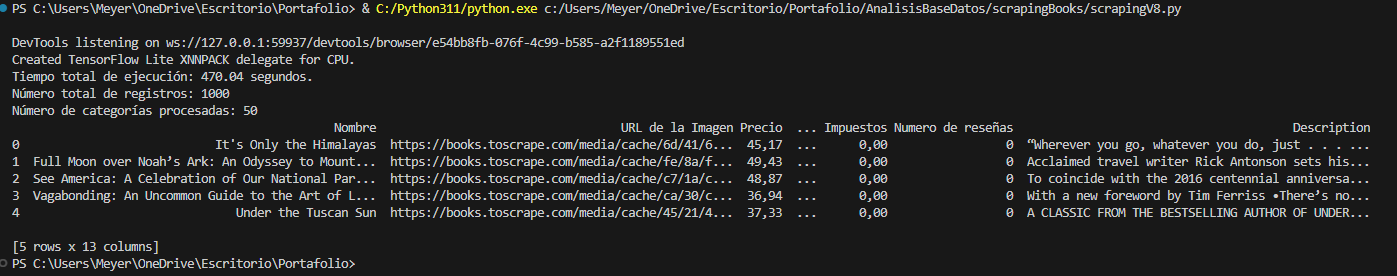

### Prueba 2.

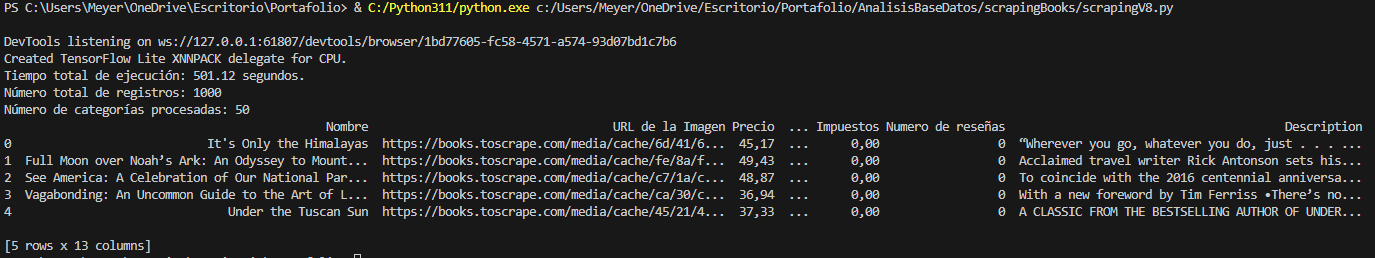

Bajo condiciones adecuadas en recursos de memoria RAM y velocidad de internet el script se compila adecuadamente.

### Archivo creado

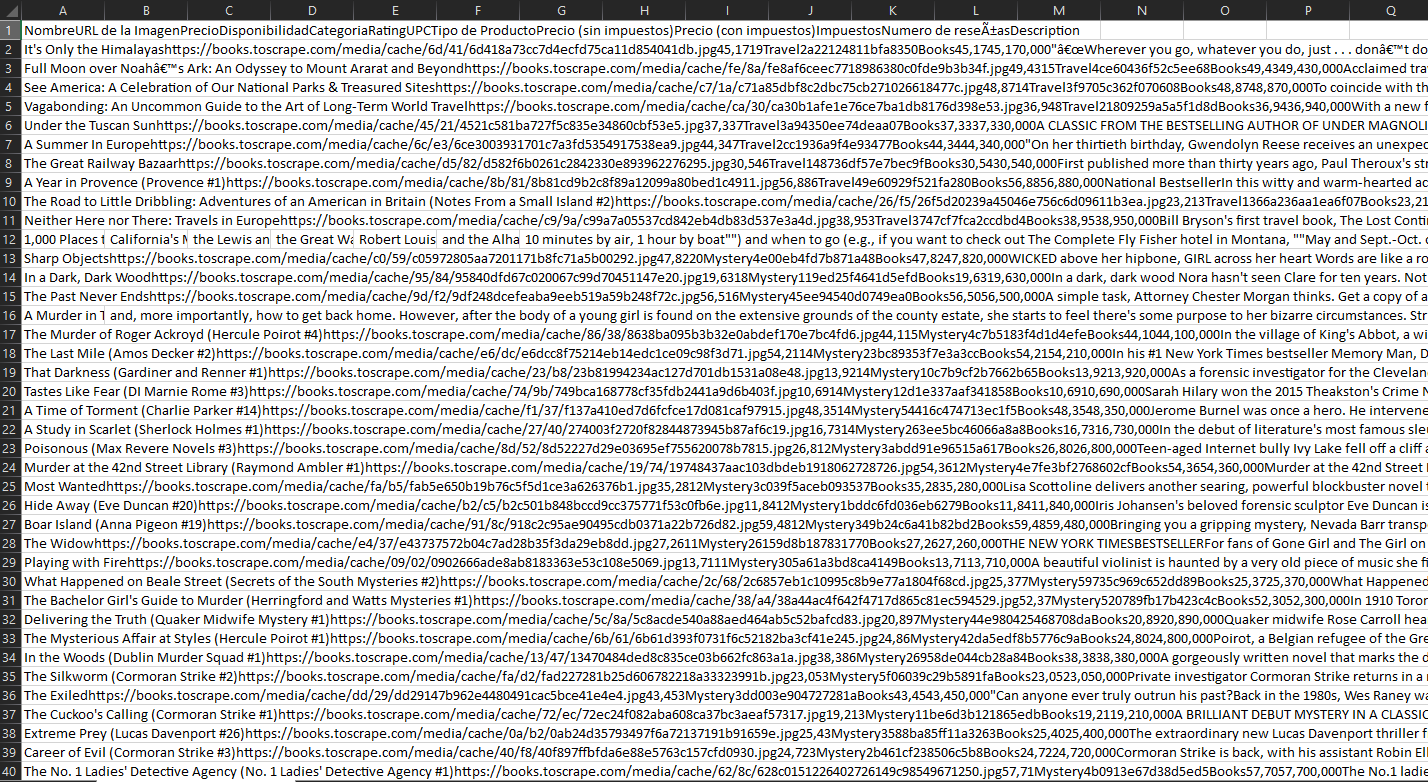

### Aplicando: Texto en columnas

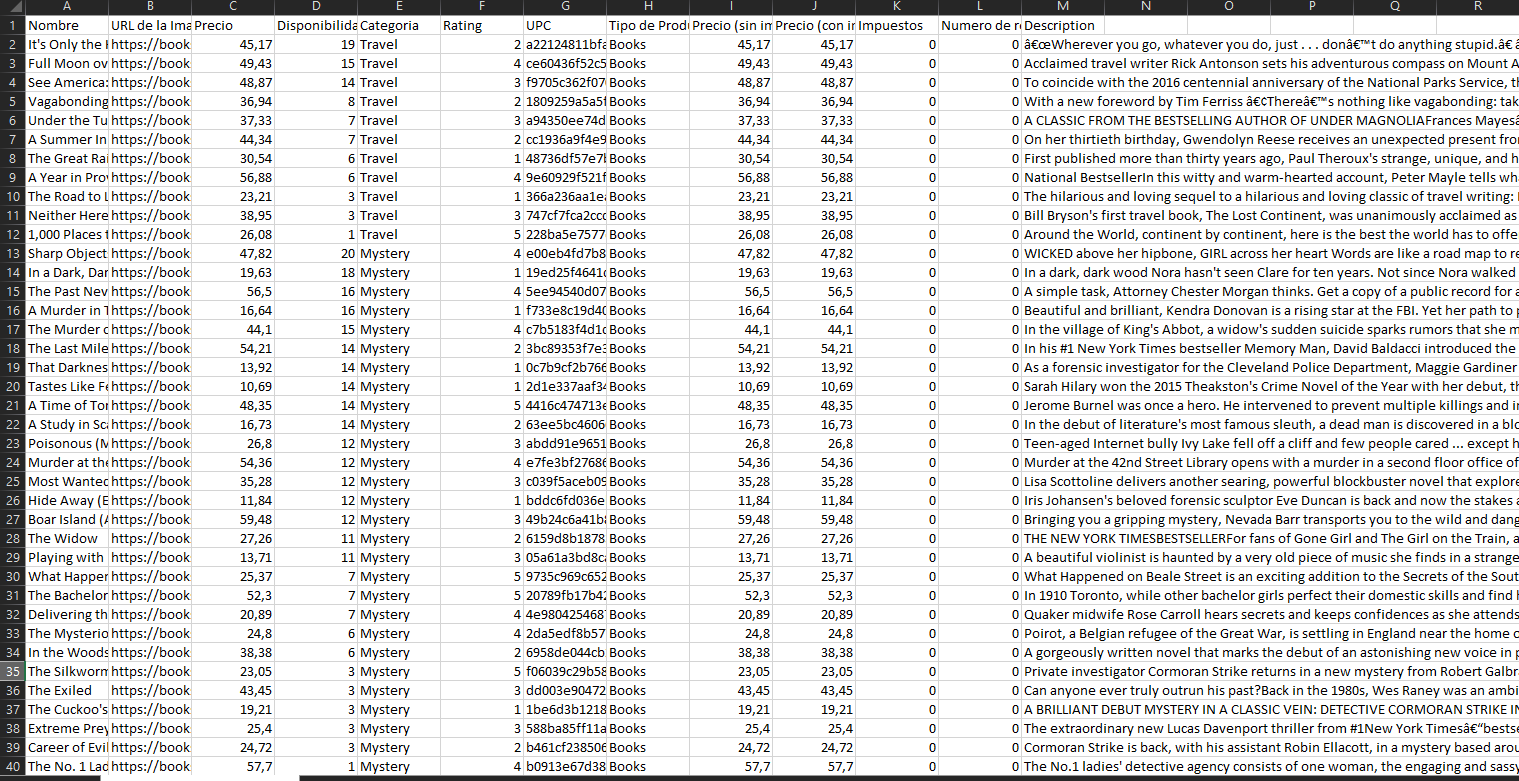

### Consideracion o error al pasar a columnas.
 Un registro tiene un \t (tab) en su descripcion asi que me genera una celda de mas para ese registro, para el resto se tiene una categorizacion adecuada.


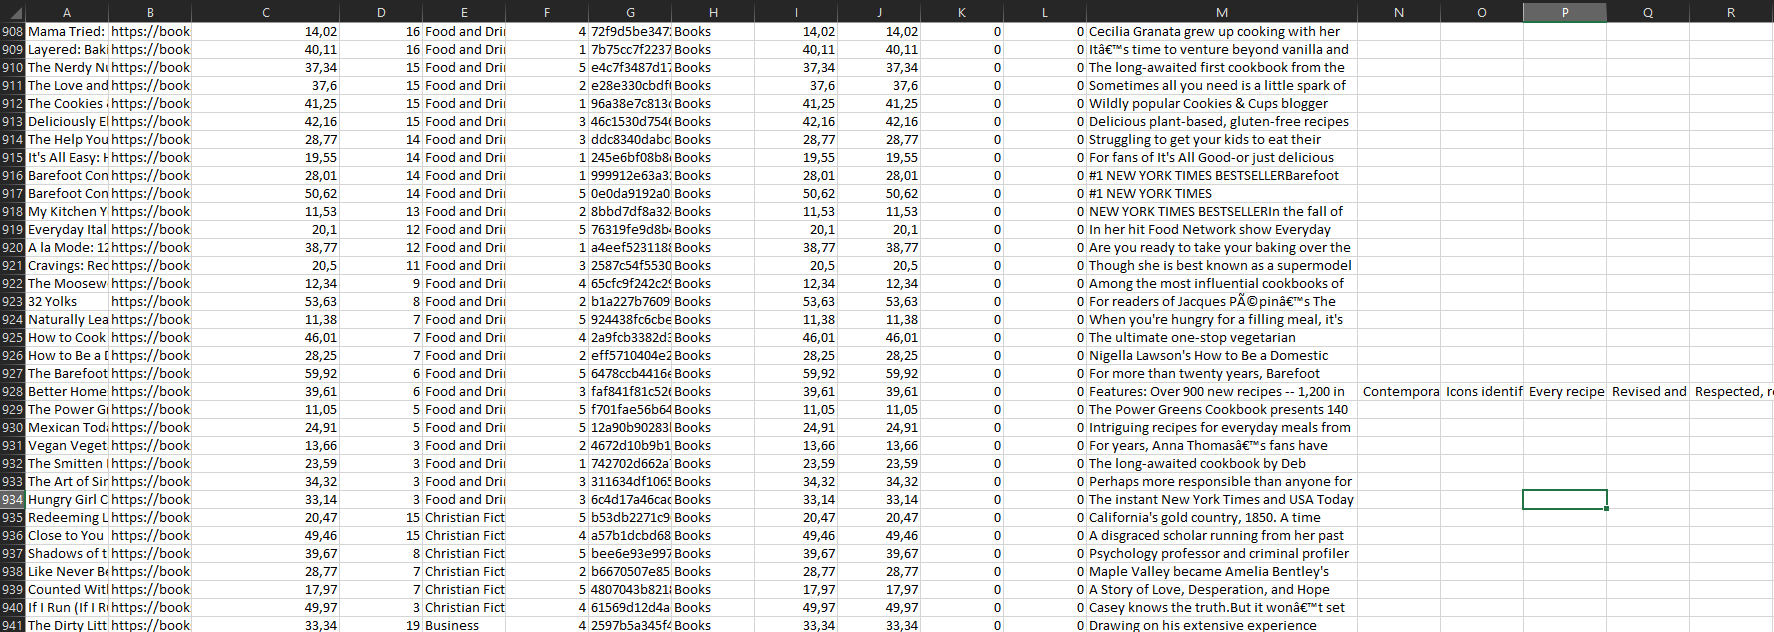